# GPU-Hours vs. Execution Time

This notebook helps to decide how to use the idle cryoem nodes. (Dec 19, 2024)

In [1]:
import os
import re
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.environ["SLURM_TIME_FORMAT"] = "%s"

In [3]:
def get_data_from_sacct(clusters: str,
                        start_date: str,
                        end_date: str,
                        partitions: str,
                        fields: str) -> pd.DataFrame:
    """Return a dataframe of the sacct output."""
    cmd = f"sacct -M {clusters} -r {partitions} -X -P -n -S {start_date} -E {end_date} -a -o {fields}"
    print(cmd)
    output = subprocess.run(cmd,
                            stdout=subprocess.PIPE,
                            shell=True,
                            timeout=100,
                            text=True,
                            check=True)
    rows = [row.split("|") for row in output.stdout.split()]
    df = pd.DataFrame(rows)
    df.columns = fields.split(",")
    return df

In [4]:
def clean_dataframe(df):
    col = "elapsedraw"
    df = df[pd.notna(df[col])]
    df = df[df[col].str.isnumeric()]
    df[col] = df[col].astype("int64")
    df = df[df[col] > 0]
    df = df[pd.notna(df["alloctres"]) & df["alloctres"].str.contains("gres/gpu=")]
    return df

In [5]:
s = "2024-06-01T00:00:00"
e = "now"
partitions = "gpu,gpu-shared,gputest"
fields = "user,elapsedraw,alloctres"
df = get_data_from_sacct("della", s, e, partitions, fields)    

sacct -M della -r gpu,gpu-shared,gputest -X -P -n -S 2024-06-01T00:00:00 -E now -a -o user,elapsedraw,alloctres


In [6]:
df = clean_dataframe(df)

In [7]:
def gpus_per_job(tres: str) -> int:
    """Return the number of allocated GPUs."""
    gpus = re.findall(r"gres/gpu=\d+", tres)
    return int(gpus[0].replace("gres/gpu=", "")) if gpus else 0

In [8]:
df["gpus_per_job"] = df["alloctres"].apply(gpus_per_job)
df["gpu-hours"] = df["gpus_per_job"] * df["elapsedraw"] / 3600

In [9]:
df["elapsed-hours"] = round(df["elapsedraw"] / 3600)
df["elapsed-hours"] = df["elapsed-hours"].astype("int64")

In [10]:
df.head()

,user,elapsedraw,alloctres,gpus_per_job,gpu-hours,elapsed-hours
0,rm3395,259500,"billing=20971,cpu=16,gres/gpu=16,mem=256G,node=4",16,1153.333333,72
1,rm3395,174789,"billing=20971,cpu=16,gres/gpu=16,mem=256G,node=4",16,776.840000,49
2,rm3395,169049,"billing=12288,cpu=1,gres/gpu=1,mem=150G,node=1",1,46.958056,47
3,rm3395,259292,"billing=5242,cpu=4,gres/gpu=4,mem=64G,node=1",4,288.102222,72
4,jweis,83761,"billing=2560,cpu=8,gres/gpu=1,mem=32000M,node=1",1,23.266944,23


## Overall Usage

Hard to choose gpus below since the nodes are shared between gpu and cryoem for gpu-test and gpu-shared.

In [11]:
days = 6 * 30.5 + 19
hours_per_day = 24
gpus = 324
overall_usage = df["gpu-hours"].sum() / (days * hours_per_day * gpus)
overall_usage

0.9984166479919596

## Elasped hours per Job vs. GPU-Hours

In [12]:
gp = df.groupby("elapsed-hours").agg({"gpu-hours":"sum", "user":lambda series: series.unique().size})
gp = gp.reset_index(drop=False).rename(columns={"user":"users"})
gp["proportion(%)"] = gp["gpu-hours"].apply(lambda x: round(100 * x / gp["gpu-hours"].sum(), 1))
gp["gpu-hours"] = gp["gpu-hours"].apply(round)
print(gp[["elapsed-hours", "gpu-hours", "proportion(%)", "users"]].to_string(index=False, justify="center"))

 elapsed-hours  gpu-hours  proportion(%)  users
       0          45613         2.9       537  
       1         123817         7.9       437  
       2          74920         4.8       318  
       3          53157         3.4       255  
       4          32846         2.1       222  
       5          37946         2.4       200  
       6          44172         2.8       185  
       7          20784         1.3       164  
       8          29754         1.9       162  
       9          29274         1.9       150  
      10          21796         1.4       148  
      11          24402         1.6       117  
      12          36949         2.4       145  
      13          17047         1.1        93  
      14          52978         3.4        87  
      15          59536         3.8       102  
      16          18917         1.2        95  
      17          16021         1.0        84  
      18          20021         1.3        76  
      19          18916         1.2     

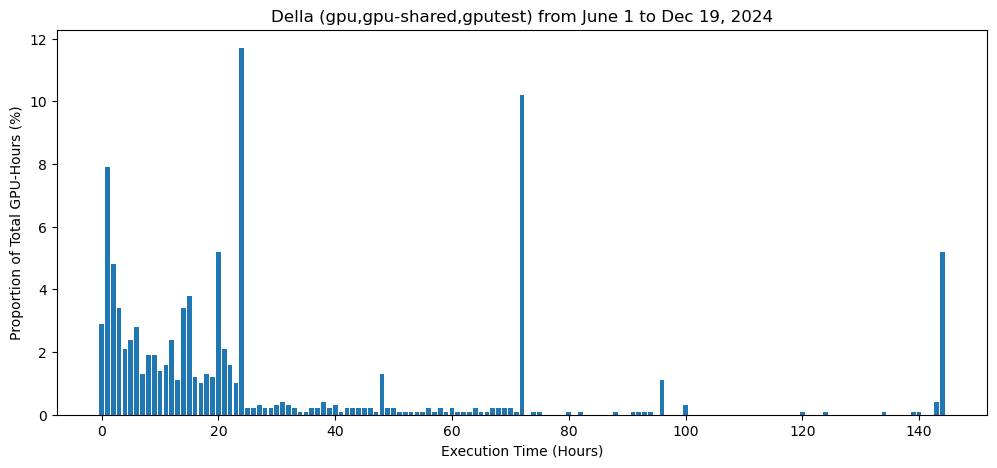

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(gp["elapsed-hours"], gp["proportion(%)"])
plt.xlabel("Execution Time (Hours)")
plt.ylabel("Proportion of Total GPU-Hours (%)")
plt.title("Della (gpu,gpu-shared,gputest) from June 1 to Dec 19, 2024")
plt.savefig("gpu_hours_vs_execution_time.jpg")

In [14]:
gp[gp["elapsed-hours"] <= 4]["proportion(%)"].sum()

21.1

In [15]:
gp[gp["elapsed-hours"] <= 8]["proportion(%)"].sum()

29.5

In [16]:
gp[gp["elapsed-hours"] <= 12]["proportion(%)"].sum()

36.8

In [17]:
gp[gp["elapsed-hours"] <= 24]["proportion(%)"].sum()

71.39999999999999

In [18]:
gp[gp["elapsed-hours"] <= 144]["proportion(%)"].sum()

99.6